In [32]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report


DATA_DIR = 'processed_data'
TRAIN_DIR = f'{DATA_DIR}/train'
VAL_DIR = f'{DATA_DIR}/val'
TEST_DIR = f'{DATA_DIR}/test'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

if not os.path.exists('results'):
    os.makedirs('results')

In [2]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 14122 images belonging to 3 classes.
Found 3099 images belonging to 3 classes.
Found 4306 images belonging to 3 classes.


In [3]:
print(f"Classes encontradas: {train_generator.class_indices}")
print(f"Total de imagens de treinamento: {train_generator.samples}")
print(f"Total de imagens de validação: {val_generator.samples}")
print(f"Total de imagens de teste: {test_generator.samples}")

Classes encontradas: {'fire': 0, 'none': 1, 'smoke': 2}
Total de imagens de treinamento: 14122
Total de imagens de validação: 3099
Total de imagens de teste: 4306


In [4]:
def base_model():
    model = Sequential([
        Conv2D(128, (3,3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(3, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def improved_model(learning_rate=0.001, dropout_rate=0.5, filters_1=32, filters_2=64,
                 filters_3=128, dense_units=128, weight_decay=0.0001, use_batch_norm=True, num_classes=3):
    model = Sequential([
        Conv2D(filters_1, (3, 3), activation='relu', padding='same',
               input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
               kernel_regularizer=l2(weight_decay)),
        BatchNormalization() if use_batch_norm else tf.keras.layers.Lambda(lambda x: x),
        MaxPooling2D((2, 2)),

        Conv2D(filters_2, (3, 3), activation='relu', padding='same',
               kernel_regularizer=l2(weight_decay)),
        BatchNormalization() if use_batch_norm else tf.keras.layers.Lambda(lambda x: x),
        MaxPooling2D((2, 2)),

        Conv2D(filters_3, (3, 3), activation='relu', padding='same',
               kernel_regularizer=l2(weight_decay)),
        BatchNormalization() if use_batch_norm else tf.keras.layers.Lambda(lambda x: x),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(dense_units, activation='relu', kernel_regularizer=l2(weight_decay)),
        BatchNormalization() if use_batch_norm else tf.keras.layers.Lambda(lambda x: x),
        Dropout(dropout_rate),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [5]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

def train_and_evaluate_model(model_fn, model_name):
    model = model_fn()
    model.summary()
    
    history = model.fit(
        train_generator,
        epochs=15,
        validation_data=val_generator,
        callbacks=[early_stopping]
    )
    
    test_metrics = model.evaluate(
        test_generator,
    )
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Acurácia do Modelo {model_name}')
    plt.ylabel('Acurácia')
    plt.xlabel('Época')
    plt.legend(['Treino', 'Validação'], loc='lower right')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Perda do Modelo {model_name}')
    plt.ylabel('Perda')
    plt.xlabel('Época')
    plt.legend(['Treino', 'Validação'], loc='upper right')
    
    plt.tight_layout()
    plt.savefig(f'results/{model_name}_learning_curves.png')
    plt.show()
    
    return model, history, test_metrics

===== Treinando o modelo base =====


2025-04-13 13:22:35.141500: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-04-13 13:22:35.141529: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-04-13 13:22:35.141537: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-04-13 13:22:35.141574: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-13 13:22:35.141855: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 128)     0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

2025-04-13 13:22:36.095223: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


442/442 [==============================] - 212s 477ms/step - loss: 1.2364 - accuracy: 0.5414 - val_loss: 3.0286 - val_accuracy: 0.4595
Epoch 2/15
442/442 [==============================] - 197s 444ms/step - loss: 4.9417 - accuracy: 0.4998 - val_loss: 4.2004 - val_accuracy: 0.5431
Epoch 3/15
442/442 [==============================] - 197s 446ms/step - loss: 5.1128 - accuracy: 0.5222 - val_loss: 5.0457 - val_accuracy: 0.5737
Epoch 4/15
442/442 [==============================] - 212s 479ms/step - loss: 5.9161 - accuracy: 0.5632 - val_loss: 3.8353 - val_accuracy: 0.6392
Epoch 5/15
442/442 [==============================] - 194s 437ms/step - loss: 9.7212 - accuracy: 0.5907 - val_loss: 33.4054 - val_accuracy: 0.4776
Epoch 6/15
135/135 [==============================] - 25s 187ms/step - loss: 3.1251 - accuracy: 0.4433


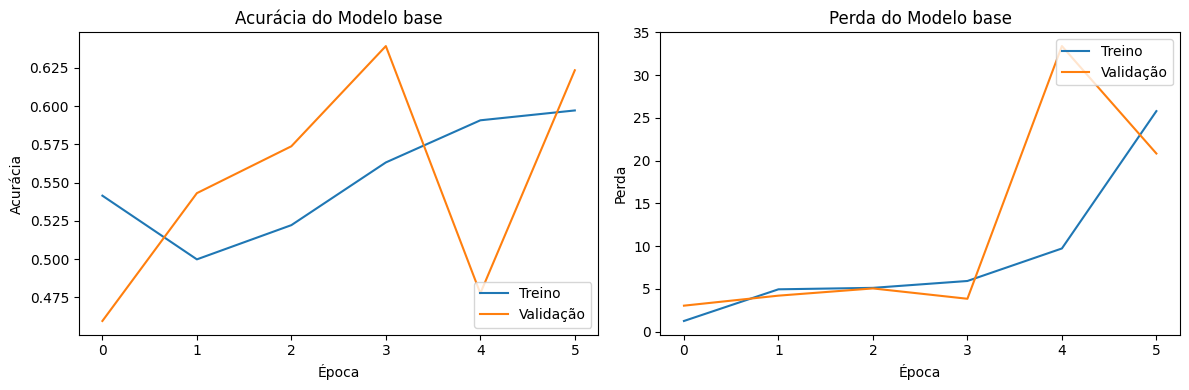

Acurácia do modelo base no teste: 0.4433


In [6]:
print("===== Treinando o modelo base =====")
base_model_trained, base_history, base_test_metrics = train_and_evaluate_model(base_model, "base")
print(f'Acurácia do modelo base no teste: {base_test_metrics[1]:.4f}')

===== Treinando o modelo melhorado =====
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 224, 224, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 112, 112, 64)      256       
 chNormalization)                                                
             

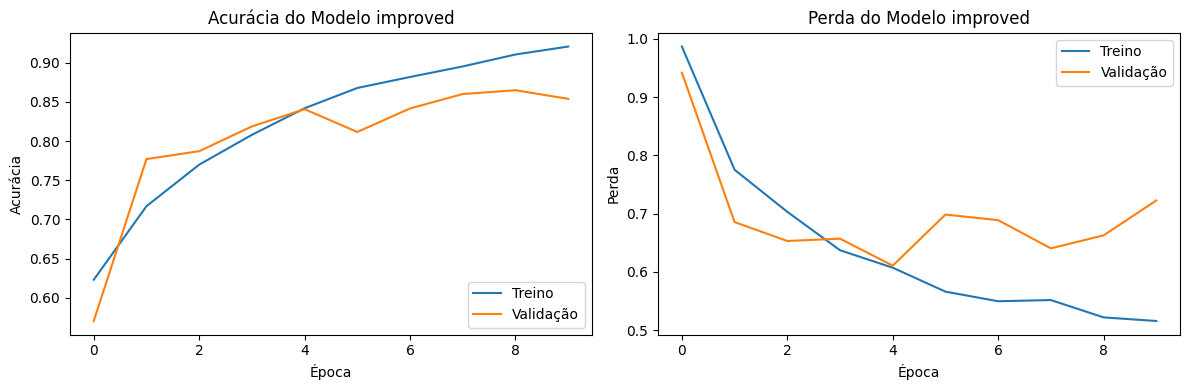

Acurácia do modelo melhorado no teste: 0.8337


In [7]:
print("===== Treinando o modelo melhorado =====")
improved_model_trained, improved_history, improved_test_metrics = train_and_evaluate_model(improved_model, "improved")
print(f'Acurácia do modelo melhorado no teste: {improved_test_metrics[1]:.4f}')

In [13]:
def create_model_for_search(learning_rate=0.001, dropout_rate=0.5, filters1=64, filters2=128, filters3=256):
    model = Sequential([
        Conv2D(filters1, (3,3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(filters2, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        Conv2D(filters3, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(3, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
param_combinations = [
    {'learning_rate': 0.001, 'dropout_rate': 0.5, 'filters1': 32, 'filters2': 64, 'filters3': 128},
    {'learning_rate': 0.0001, 'dropout_rate': 0.3, 'filters1': 64, 'filters2': 128, 'filters3': 256},
    {'learning_rate': 0.01, 'dropout_rate': 0.7, 'filters1': 32, 'filters2': 128, 'filters3': 256}
]

results = []
for i, params in enumerate(param_combinations):
    print(f"Training model {i+1}/{len(param_combinations)} with params: {params}")
    
    model = create_model_for_search(**params)
    
    history = model.fit(
        train_generator,
        epochs=5,
        validation_data=val_generator,
        callbacks=[early_stopping],
        verbose=1
    )
    
    val_accuracy = max(history.history['val_accuracy'])
    results.append((params, val_accuracy))
    
    print(f"Validation accuracy: {val_accuracy:.4f}")
    print("-" * 50)


best_result = max(results, key=lambda x: x[1])
best_params = best_result[0]
best_accuracy = best_result[1]


Training model 1/3 with params: {'learning_rate': 0.001, 'dropout_rate': 0.5, 'filters1': 32, 'filters2': 64, 'filters3': 128}
Epoch 1/5
442/442 [==============================] - 137s 305ms/step - loss: 0.9300 - accuracy: 0.6345 - val_loss: 0.6948 - val_accuracy: 0.6973
Epoch 2/5
442/442 [==============================] - 130s 293ms/step - loss: 0.6195 - accuracy: 0.7443 - val_loss: 0.5950 - val_accuracy: 0.7419
Epoch 3/5
442/442 [==============================] - 145s 327ms/step - loss: 0.4938 - accuracy: 0.8012 - val_loss: 0.4415 - val_accuracy: 0.8187
Epoch 4/5
442/442 [==============================] - 142s 317ms/step - loss: 0.3994 - accuracy: 0.8455 - val_loss: 0.3863 - val_accuracy: 0.8470
Epoch 5/5
442/442 [==============================] - 134s 302ms/step - loss: 0.3107 - accuracy: 0.8845 - val_loss: 0.4934 - val_accuracy: 0.7974
Validation accuracy: 0.8470
--------------------------------------------------
Training model 2/3 with params: {'learning_rate': 0.0001, 'dropout_ra

In [38]:
print("Melhores parâmetros encontrados:")
print(best_params)
print(f"Melhor acurácia: {best_accuracy:.4f}")

Melhores parâmetros encontrados:
{'learning_rate': 0.001, 'dropout_rate': 0.5, 'filters1': 32, 'filters2': 64, 'filters3': 128}
Melhor acurácia: 0.8470


In [40]:
final_model = create_model_for_search(**best_params)

final_history = final_model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

final_test_loss, final_test_acc = final_model.evaluate(
    test_generator,)

print(f'Acurácia final no teste: {final_test_acc:.4f}')

Epoch 1/10
442/442 [==============================] - 133s 297ms/step - loss: 0.9581 - accuracy: 0.6188 - val_loss: 0.8141 - val_accuracy: 0.6657
Epoch 2/10
442/442 [==============================] - 131s 296ms/step - loss: 0.6632 - accuracy: 0.7197 - val_loss: 0.6086 - val_accuracy: 0.7112
Epoch 3/10
442/442 [==============================] - 131s 296ms/step - loss: 0.5304 - accuracy: 0.7870 - val_loss: 0.4671 - val_accuracy: 0.8193
Epoch 4/10
442/442 [==============================] - 132s 298ms/step - loss: 0.4423 - accuracy: 0.8267 - val_loss: 0.4773 - val_accuracy: 0.8061
Epoch 5/10
442/442 [==============================] - 130s 294ms/step - loss: 0.3726 - accuracy: 0.8558 - val_loss: 0.4058 - val_accuracy: 0.8422
Epoch 6/10
442/442 [==============================] - 128s 289ms/step - loss: 0.3004 - accuracy: 0.8885 - val_loss: 0.3573 - val_accuracy: 0.8690
Epoch 7/10
442/442 [==============================] - 130s 293ms/step - loss: 0.2601 - accuracy: 0.9059 - val_loss: 0.4189 -

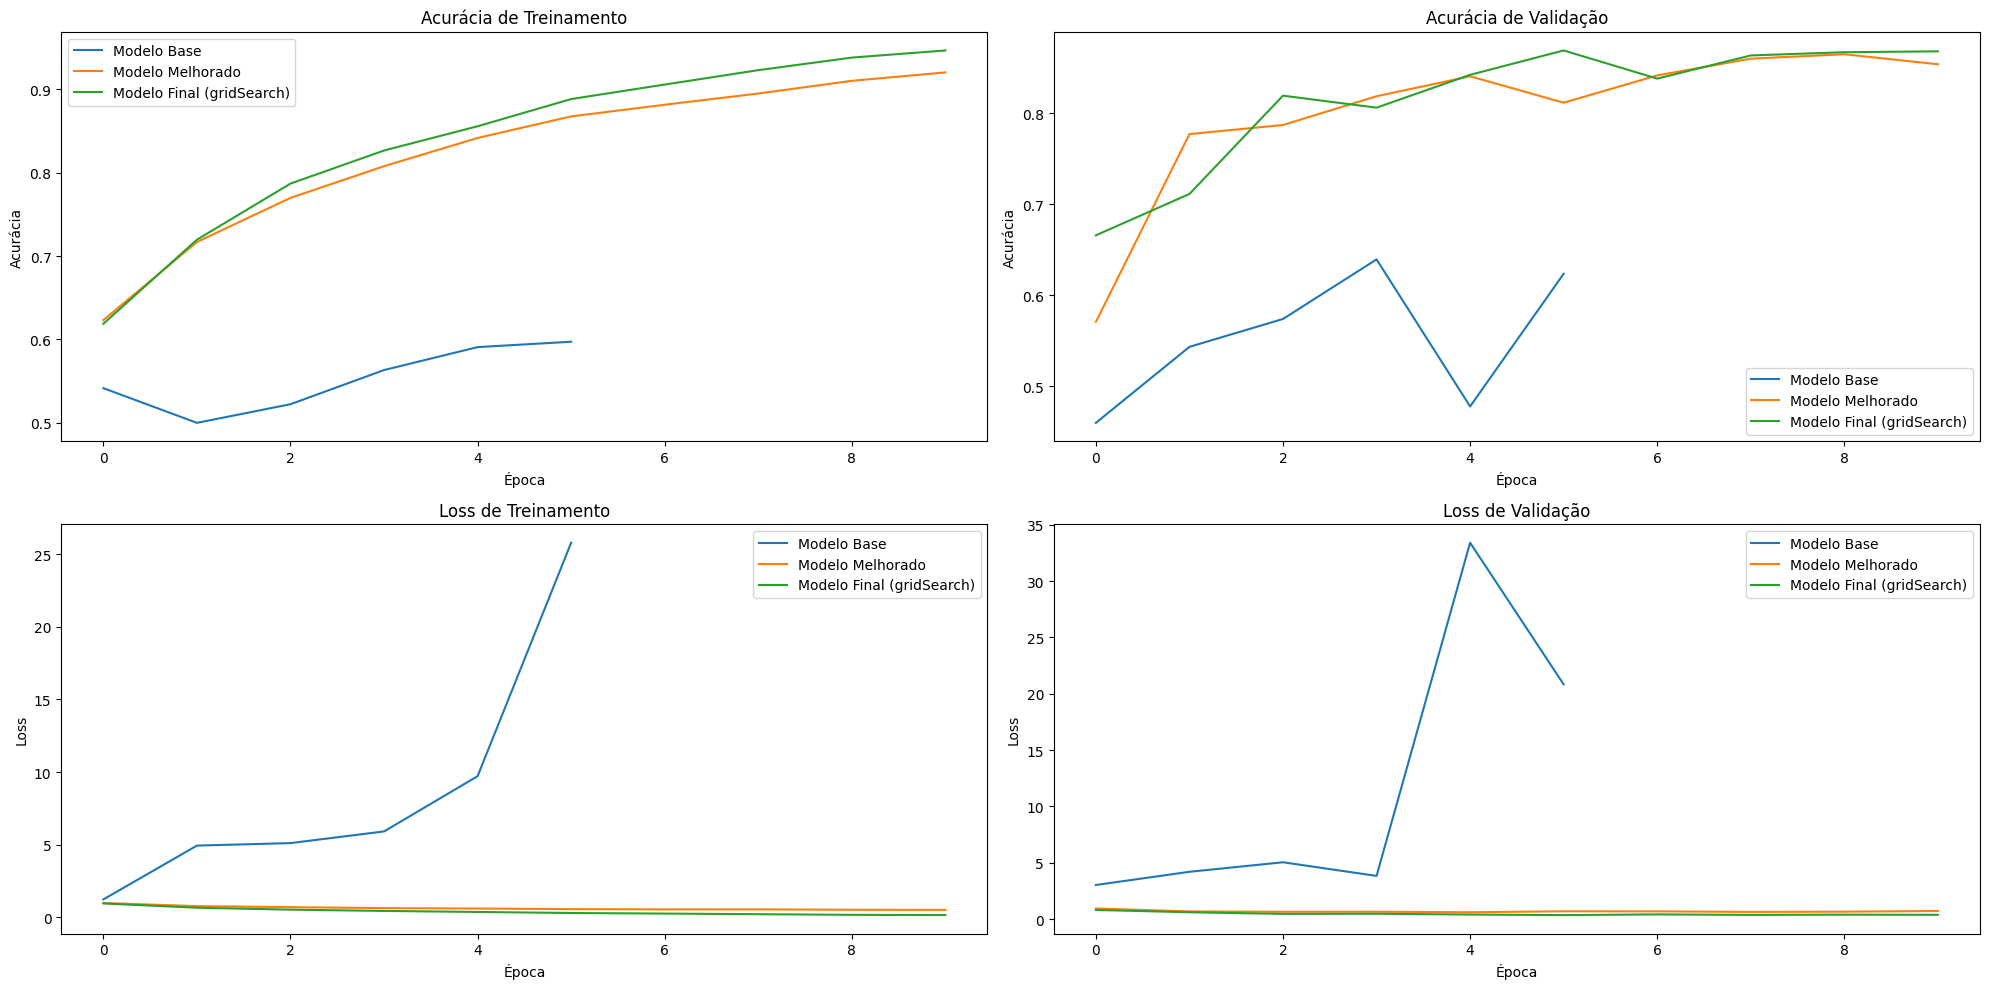

Comparação de desempenho no conjunto de teste:
Acurácia do modelo base: 0.4433
Acurácia do modelo melhorado: 0.8337
Acurácia do modelo final (gridSearch): 0.8572


In [85]:
plt.figure(figsize=(20, 10))

plt.subplot(2, 2, 1)
plt.plot(base_history.history['accuracy'], label='Modelo Base')
plt.plot(improved_history.history['accuracy'], label='Modelo Melhorado')
plt.plot(final_history.history['accuracy'], label='Modelo Final (gridSearch)')
plt.title('Acurácia de Treinamento')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(base_history.history['val_accuracy'], label='Modelo Base')
plt.plot(improved_history.history['val_accuracy'], label='Modelo Melhorado')
plt.plot(final_history.history['val_accuracy'], label='Modelo Final (gridSearch)')
plt.title('Acurácia de Validação')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(base_history.history['loss'], label='Modelo Base')
plt.plot(improved_history.history['loss'], label='Modelo Melhorado')
plt.plot(final_history.history['loss'], label='Modelo Final (gridSearch)')
plt.title('Loss de Treinamento')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(base_history.history['val_loss'], label='Modelo Base')
plt.plot(improved_history.history['val_loss'], label='Modelo Melhorado')
plt.plot(final_history.history['val_loss'], label='Modelo Final (gridSearch)')
plt.title('Loss de Validação')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('results/all_models_comparison.png')
plt.show()

print("Comparação de desempenho no conjunto de teste:")
print(f'Acurácia do modelo base: {base_test_metrics[1]:.4f}')
print(f'Acurácia do modelo melhorado: {improved_test_metrics[1]:.4f}')
print(f'Acurácia do modelo final (gridSearch): {final_test_acc:.4f}')

In [42]:
def generate_confusion_matrix(model, generator, model_name):
    generator.reset()
    y_pred = model.predict(generator, steps=generator.samples // BATCH_SIZE + 1)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    y_true = generator.classes[:len(y_pred_classes)]
    
    cm = confusion_matrix(y_true, y_pred_classes)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=list(generator.class_indices.keys()),
                yticklabels=list(generator.class_indices.keys()))
    plt.xlabel('Previsão')
    plt.ylabel('Verdadeiro')
    plt.title(f'Matriz de Confusão - {model_name}')
    plt.savefig(f'results/confusion_matrix_{model_name}.png')
    plt.show()
    
    print(f"Relatório de Classificação - {model_name}:")
    print(classification_report(
        y_true, 
        y_pred_classes, 
        target_names=list(generator.class_indices.keys())
    ))
    
    return y_true, y_pred_classes

Gerando matriz de confusão para o modelo base...
135/135 [==============================] - 24s 176ms/step


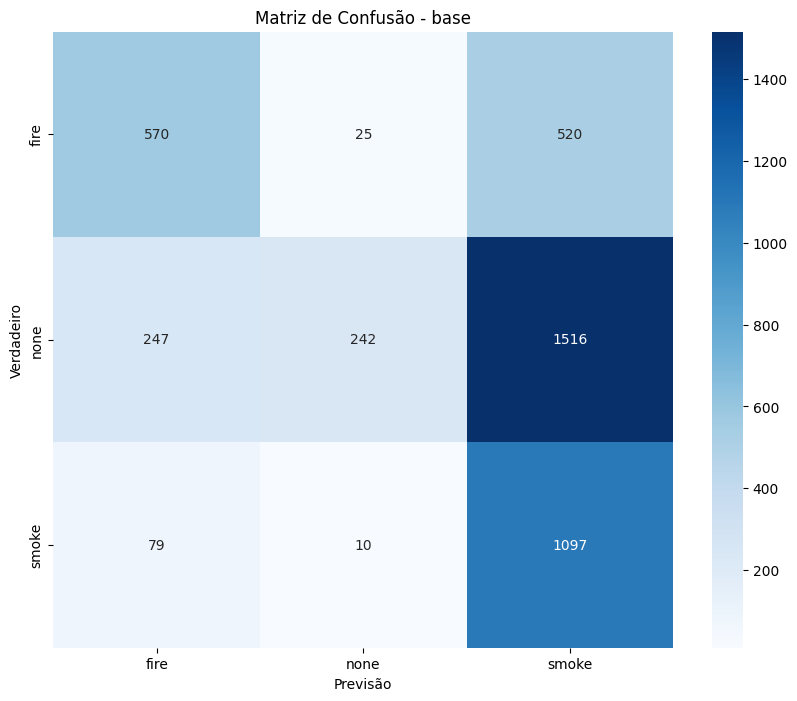

Relatório de Classificação - base:
              precision    recall  f1-score   support

        fire       0.64      0.51      0.57      1115
        none       0.87      0.12      0.21      2005
       smoke       0.35      0.92      0.51      1186

    accuracy                           0.44      4306
   macro avg       0.62      0.52      0.43      4306
weighted avg       0.67      0.44      0.39      4306

Gerando matriz de confusão para o modelo melhorado...
135/135 [==============================] - 23s 168ms/step


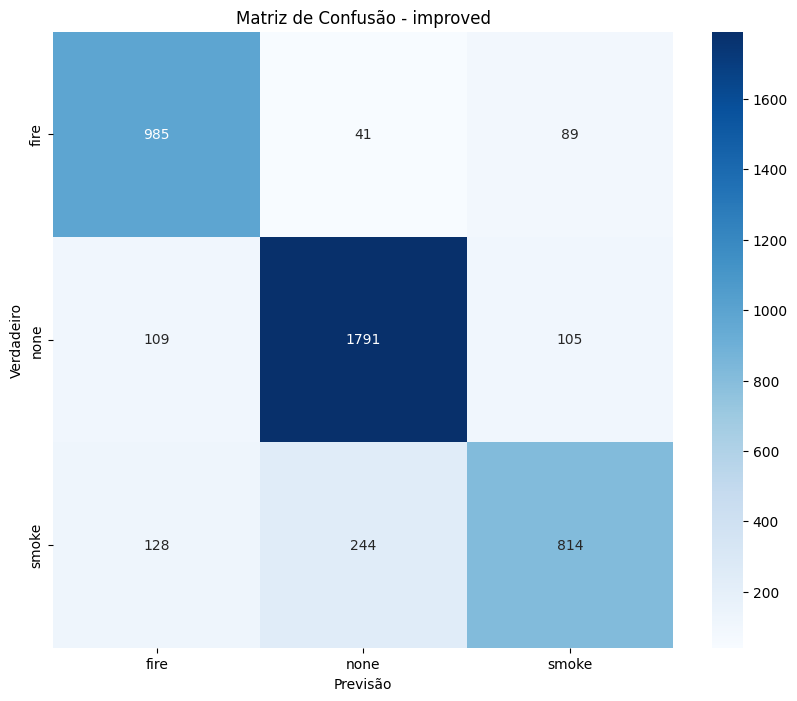

Relatório de Classificação - improved:
              precision    recall  f1-score   support

        fire       0.81      0.88      0.84      1115
        none       0.86      0.89      0.88      2005
       smoke       0.81      0.69      0.74      1186

    accuracy                           0.83      4306
   macro avg       0.83      0.82      0.82      4306
weighted avg       0.83      0.83      0.83      4306

Gerando matriz de confusão para o modelo final...
135/135 [==============================] - 20s 149ms/step


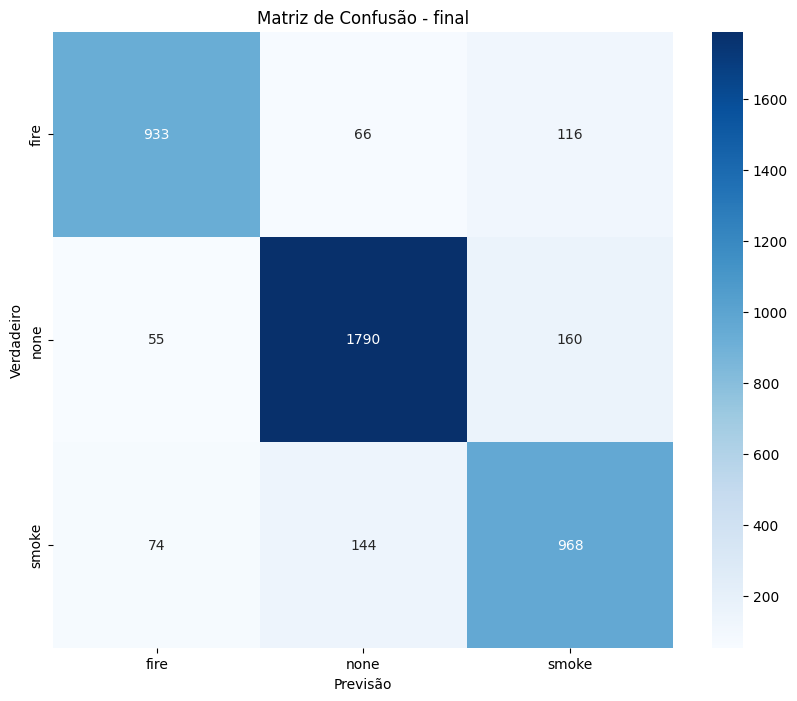

Relatório de Classificação - final:
              precision    recall  f1-score   support

        fire       0.88      0.84      0.86      1115
        none       0.90      0.89      0.89      2005
       smoke       0.78      0.82      0.80      1186

    accuracy                           0.86      4306
   macro avg       0.85      0.85      0.85      4306
weighted avg       0.86      0.86      0.86      4306



In [43]:
print("Gerando matriz de confusão para o modelo base...")
base_y_true, base_y_pred = generate_confusion_matrix(base_model_trained, test_generator, "base")

print("Gerando matriz de confusão para o modelo melhorado...")
improved_y_true, improved_y_pred = generate_confusion_matrix(improved_model_trained, test_generator, "improved")

print("Gerando matriz de confusão para o modelo final...")
final_y_true, final_y_pred = generate_confusion_matrix(final_model, test_generator, "final")

In [ ]:
def visualize_predictions(model, generator, model_name):
    generator.reset()

    class_names = list(generator.class_indices.keys())
    num_classes = len(class_names)

    correct_examples = [None] * num_classes
    incorrect_examples = [None] * num_classes

    class_counts = np.zeros(num_classes, dtype=int)
    correct_counts = np.zeros(num_classes, dtype=int)
    incorrect_counts = np.zeros(num_classes, dtype=int)

    all_batches = generator.samples // generator.batch_size + (1 if generator.samples % generator.batch_size > 0 else 0)

    for batch_idx in range(all_batches):
        try:
            batch_x, batch_y = next(generator)
            batch_pred = model.predict(batch_x, verbose=0)

            true_classes = np.argmax(batch_y, axis=1)
            pred_classes = np.argmax(batch_pred, axis=1)

            for true_class in true_classes:
                class_counts[true_class] += 1

            for i in range(len(batch_x)):
                true_class = true_classes[i]
                pred_class = pred_classes[i]

                if true_class == pred_class:
                    correct_counts[true_class] += 1
                    if correct_examples[true_class] is None:
                        correct_examples[true_class] = (batch_x[i], true_class, pred_class)
                else:
                    incorrect_counts[true_class] += 1
                    if incorrect_examples[true_class] is None:
                        incorrect_examples[true_class] = (batch_x[i], true_class, pred_class)
        except StopIteration:
            break
    for class_idx in range(num_classes):
        if incorrect_examples[class_idx] is None and correct_counts[class_idx] > 0:
            if correct_examples[class_idx] is not None:
                img, true, _ = correct_examples[class_idx]
                fake_pred = (true + 1) % num_classes
                incorrect_examples[class_idx] = (img, true, fake_pred)

        if correct_examples[class_idx] is None and incorrect_counts[class_idx] > 0:
            if incorrect_examples[class_idx] is not None:
                img, true, _ = incorrect_examples[class_idx]
                correct_examples[class_idx] = (img, true, true)

    plt.figure(figsize=(12, 4 * num_classes))

    for class_idx in range(num_classes):
        plt.subplot(num_classes, 2, 2 * class_idx + 1)
        if correct_examples[class_idx]:
            img, true, pred = correct_examples[class_idx]
            plt.imshow(img)
            plt.title(f"Correto\nClasse: {class_names[true]}\nPredição: {class_names[pred]}", color='green')
        else:
            plt.text(0.5, 0.5, f"Nenhum exemplo correto encontrado para {class_names[class_idx]}", ha='center', va='center')
        plt.axis('off')

        plt.subplot(num_classes, 2, 2 * class_idx + 2)
        if incorrect_examples[class_idx]:
            img, true, pred = incorrect_examples[class_idx]
            plt.imshow(img)
            plt.title(f"Incorreto\nClasse: {class_names[true]}\nPredição: {class_names[pred]}", color='red')
        else:
            plt.text(0.5, 0.5, f"Nenhum exemplo incorreto encontrado para {class_names[class_idx]}", ha='center', va='center')
        plt.axis('off')

    plt.suptitle(f'Previsões do Modelo {model_name}', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.savefig(f'results/predictions_{model_name}.png')
    plt.show()

Visualizando previsões do modelo base...


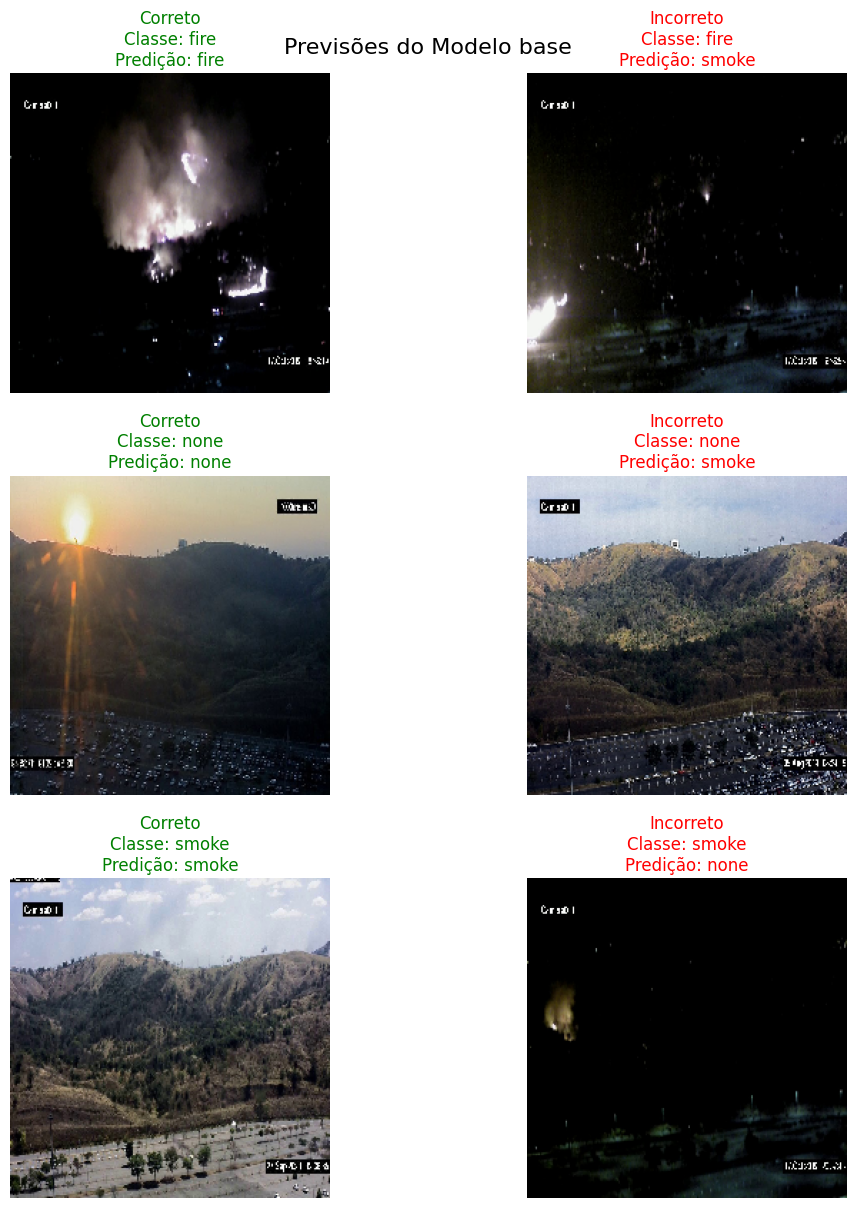

Visualizando previsões do modelo melhorado...


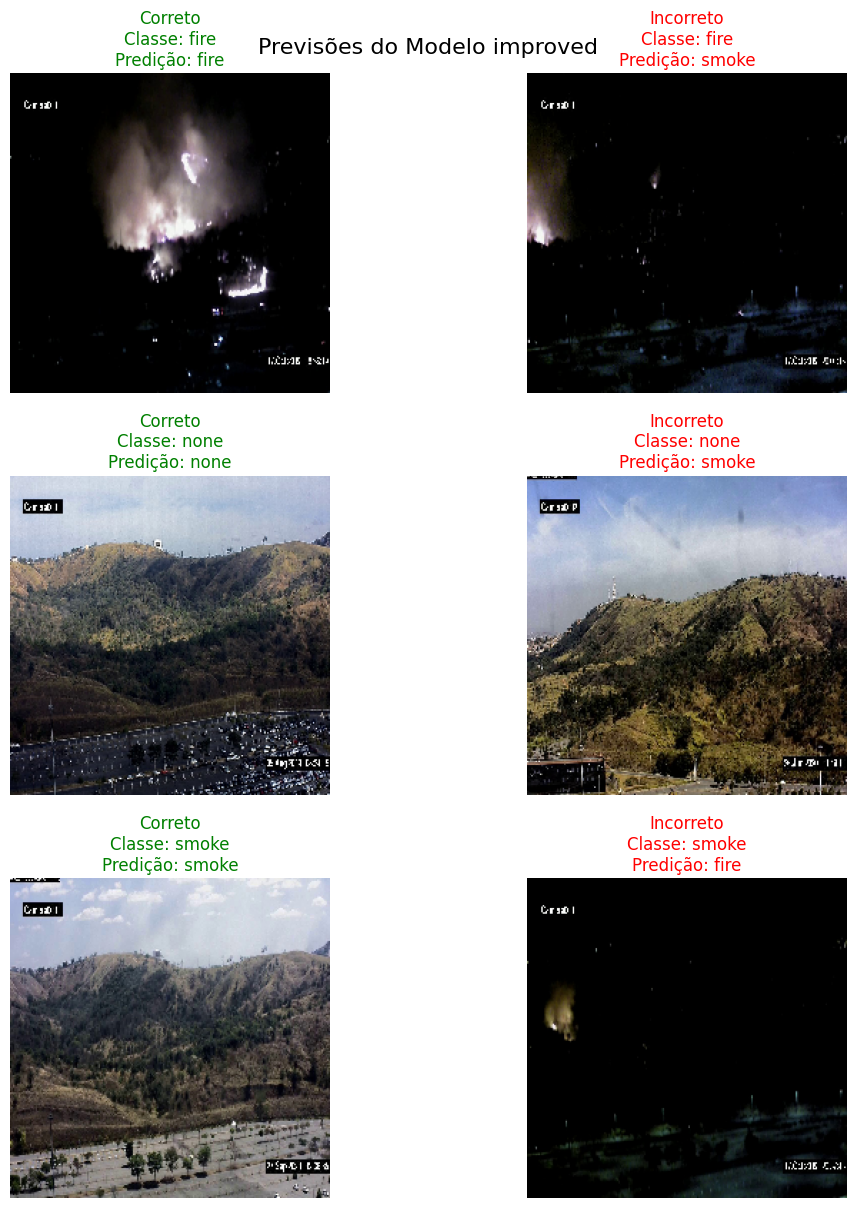

Visualizando previsões do modelo final...


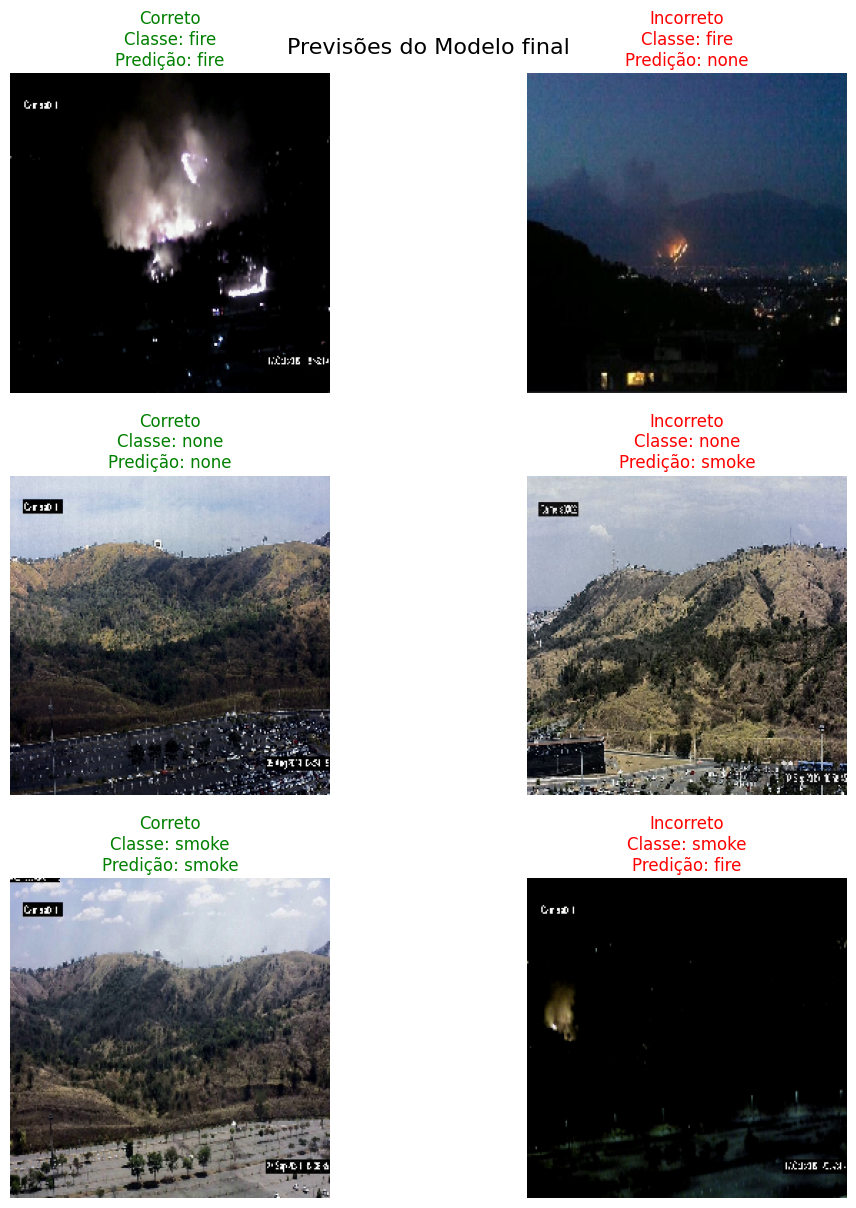

In [84]:
print("Visualizando previsões do modelo base...")
visualize_predictions(base_model_trained, test_generator, "base")

print("Visualizando previsões do modelo melhorado...")
visualize_predictions(improved_model_trained, test_generator, "improved")

print("Visualizando previsões do modelo final...")
visualize_predictions(final_model, test_generator, "final")

In [47]:
def visualize_feature_maps(model, img):
    layer_outputs = [layer.output for layer in model.layers if 'conv2d' in layer.name]
    activation_model = Model(inputs=model.input, outputs=layer_outputs[0])
    
    img_tensor = np.expand_dims(img, axis=0)
    
    activations = activation_model.predict(img_tensor)
    
    plt.figure(figsize=(15, 8))
    
    plt.subplot(4, 8, 1)
    plt.imshow(img)
    plt.title('Imagem Original')
    plt.axis('off')
    
    for i in range(min(31, activations.shape[3])):
        plt.subplot(4, 8, i + 2)
        plt.imshow(activations[0, :, :, i], cmap='viridis')
        plt.title(f'Filtro {i+1}')
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('results/feature_maps.png')
    plt.show()

test_generator.reset()
sample_images, _ = next(test_generator)
sample_image = sample_images[0]

1/1 [==============================] - 0s 85ms/step


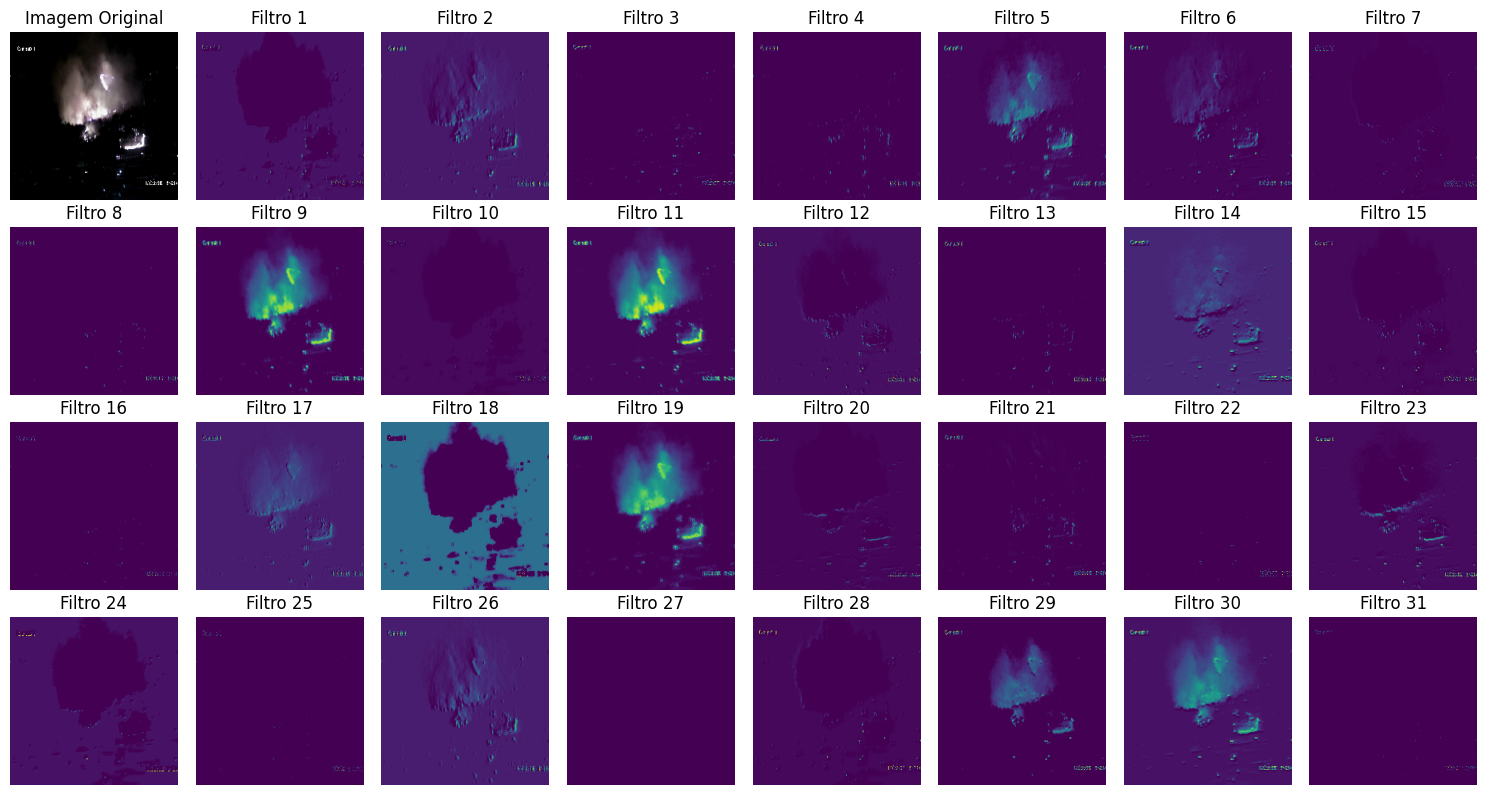

In [48]:
visualize_feature_maps(final_model, sample_image)